In [135]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

# Print pandas.describe() in PDF
from prettytable import PrettyTable

# converting created dates from reddit API into human readable format
from datetime import datetime, timedelta

In [136]:
# Disable automated output
import warnings
# Future deprecation warnings
warnings.filterwarnings("ignore")
import logging
# Set logging level to suppress INFO messages
logging.getLogger('mlflow').setLevel(logging.WARNING)

In [137]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load NLTK Libraries

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Downloading NLTK's databases
nltk.download('vader_lexicon', quiet=True); # get lexicons data
nltk.download('punkt', quiet=True); # for tokenizer
nltk.download('stopwords', quiet=True); # dictionary for tokenization


In [138]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

# Reddit Subreddit API analysis

Subreddit Stats
+-------+------------+----------------------+-------------+----------------------+-----------------+
| index | Unnamed: 0 |         name         | subscribers |     display_name     | subscribers_pct |
+-------+------------+----------------------+-------------+----------------------+-----------------+
|   1   |     1      |       chatgpt        |   4454878   |       chatgpt        |      36.37      |
|   4   |     4      |   machinelearning    |   2868976   |   machinelearning    |      23.42      |
|   29  |     7      |     datascience      |   1360056   |     datascience      |      11.10      |
|   37  |     4      |        openai        |   1116358   |        OpenAI        |       9.11      |
|   17  |     2      |         gpt3         |    718960   |         GPT3         |       5.87      |
|   0   |     0      |      artificial      |    714343   |      artificial      |       5.83      |
|   3   |     3      | learnmachinelearning |    383519   | learnmachinelea

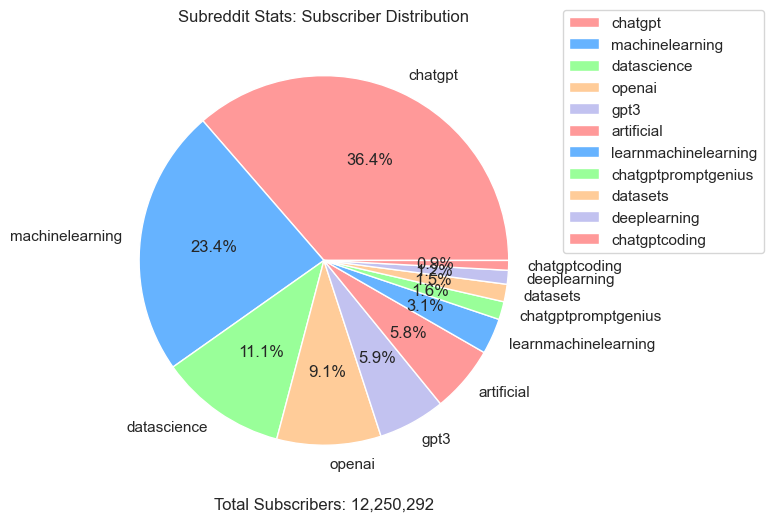

In [139]:
# Reddit metadata structure
subreddit_dict = {  "name":[],
                    "subscribers":[] }

# Import subreddit metadata
metadata = pd.DataFrame()
for fname in glob.iglob(os.path.abspath('./data/**/*.meta'), recursive=True):
    _metadata = pd.read_csv(fname)
    _metadata['display_name'] = _metadata['name']
    _metadata['name'] = _metadata['name'].str.lower()
    metadata = metadata.append(_metadata.copy(), ignore_index=True)
    #print(fname)
    #break #DEBUG

# Drop duplicates from the 'name' column
metadata.reset_index(inplace=True)  # Reset index
metadata.drop_duplicates(subset='name', inplace=True)  # Drop duplicates based on the 'name' column
metadata.sort_values(by='subscribers', ascending=False, inplace=True)

# filter subreddits with less than 100,000 subscribers
metadata = metadata[metadata['subscribers'] > 100000]
# Calculate subscribers as a percentage of the total
total_subscribers = metadata['subscribers'].sum()
metadata['subscribers_pct'] = (metadata['subscribers'] / total_subscribers) * 100

print('Subreddit Stats')
# Create a PrettyTable object
table = PrettyTable()
# Add columns to the table
table.field_names = metadata.columns
# Add rows to the table
for row in metadata.itertuples(index=False):
    # Set the float format for all float columns
    float_format = "{:.2f}"
    # Format float values
    row = [float_format.format(value) if isinstance(value, float) else value for value in row]
    table.add_row(row)
# Print the table
print(table)

# After printing, set name as the index
metadata.set_index('name', inplace=True)  # Set the 'name' column as the index of the DataFrame

# Plot pie chart of sentiment label distribution
plt.figure(figsize=(8, 6))
metadata['subscribers_pct'].plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
# Add annotations for subscriber percentages
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.title('Subreddit Stats: Subscriber Distribution')
plt.ylabel('')
plt.xlabel('Total Subscribers: ' + "{:,}".format(total_subscribers))
plt.show()

# Reddit Search API data analysis

In [140]:
# Reddit data structure
topics_dict_template = {"subreddit":[],
                        "query":[],
                        "sort":[],
                        "date":[],
                        "title":[],
                        "author":[],
                        "stickied":[],
                        "upvote_ratio":[],
                        "score":[],
                        "id":[],
                        "url":[],
                        "num_comments": [],
                        "created": [],
                        "body":[]}

# Import query data
df = pd.DataFrame()
running_total = 0
for fname in glob.glob(os.path.abspath('./data/**/*.csv'), recursive=True):
    _df=pd.read_csv(fname)
    if _df.empty: continue
    _df['subreddit'] = _df[_df['subreddit'].str.lower().isin(metadata.index)]['subreddit'].str.lower()
    _df['score_weighted'] = _df.apply(lambda row: row['score'] * (100 - metadata.loc[row['subreddit']]['subscribers_pct']), axis=1)
    _df['num_comments_weighted'] = _df.apply(lambda row: row['num_comments'] * (100 - metadata.loc[row['subreddit']]['subscribers_pct']), axis=1)
    _df['date'] = pd.to_datetime(_df['date']) # convert date column
    df = df.append(_df.copy(), ignore_index=True)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG

# remove duplicate posts
df.reset_index(inplace=True)  # Reset index
df.drop_duplicates(subset='id', inplace=True)  # Drop duplicates based on the 'id' column
df.set_index('id', inplace=True)  # Set the 'id' column as the index of the DataFrame

print(f"Total imported Reddit posts: {running_total}")
print(f"Duplicate cross-subreddit posts: {running_total-len(df)}")
print(f"De-duplicated reddit posts: {len(df)}")

Total imported Reddit posts: 50472
Duplicate cross-subreddit posts: 44718
De-duplicated reddit posts: 5754


# VADER sentiment analysis

In [141]:
# Clean data

#Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove :
    return text

#Next we have to remove emoji & Unicode from the Tweet data.
def remove_emoji(string):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [142]:
def vader_sentiment(dataset):
    # VADER sentiment analysis
    sid = SentimentIntensityAnalyzer()

    dataset[['pos', 'neg', 'neu', 'compound']] = dataset['clean'].apply(lambda text: pd.Series(sid.polarity_scores(text)))

    # Threshold conditions determine the value of the sentiment of the text
    THRESHOLD = 0.2
    conditions = [
        (dataset['compound'] <= -THRESHOLD),
        (dataset['compound'] > -THRESHOLD) & (dataset['compound'] < THRESHOLD),
        (dataset['compound'] >= THRESHOLD),
        ]
    values = ["neg", "neu", "pos"]
    dataset['label'] = np.select(conditions, values)

    # Convert all sentiment columns to numeric type
    dataset[['pos', 'neg', 'neu', 'compound']] = dataset[['pos', 'neg', 'neu', 'compound']].apply(pd.to_numeric, errors='coerce')


In [143]:
# remove rows without a comment body
df.dropna(subset='body', how="any", inplace=True)

df['clean'] = df['body'].apply(lambda x: remove_emoji(cleanTxt(x)))

In [144]:
# Define the date range for GPT-3 hype analysis
gpt3_start = datetime(2022, 11, 1)
gpt3_end = datetime(2023, 1, 31)

# Define the date range for GPT-4 hype analysis
gpt4_start = datetime(2023, 2, 15)
gpt4_launch =  datetime(2023, 3, 14)
gpt4_end = datetime(2023, 5, 15)

# get the distance of the date to the GPT-4 launch date
df['launch_distance'] = abs(gpt4_launch - df['date'])
df['launch_distance_f'] = df['launch_distance'] / pd.to_timedelta(1, unit='D')

# Filter datasets
df_gpt3 = df[(gpt3_start <= df['date']) & (df['date'] < gpt3_end + timedelta(days=1))]

# Split at gpt4_launch date
df_gpt4_before = df[(gpt4_start <= df['date']) & (df['date'] < gpt4_launch)]
df_gpt4_after = df[(gpt4_launch <= df['date']) & (df['date'] < gpt4_end + timedelta(days=1))]

# apply vader sentiment to matched datasets
vader_sentiment(df_gpt3)
vader_sentiment(df_gpt4_before)
vader_sentiment(df_gpt4_after)

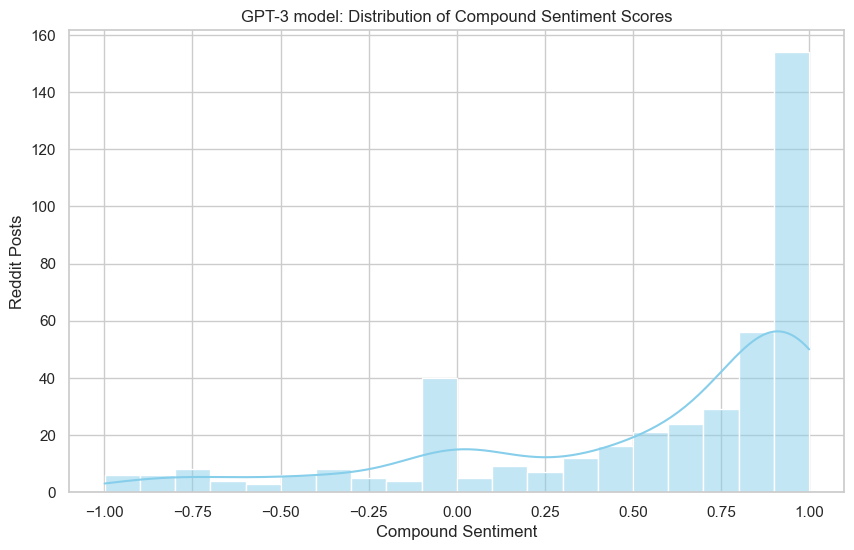

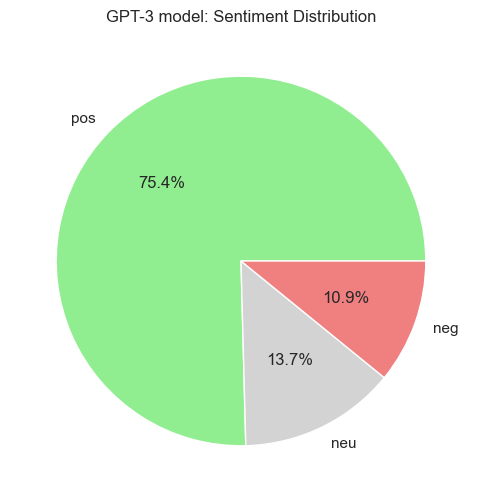

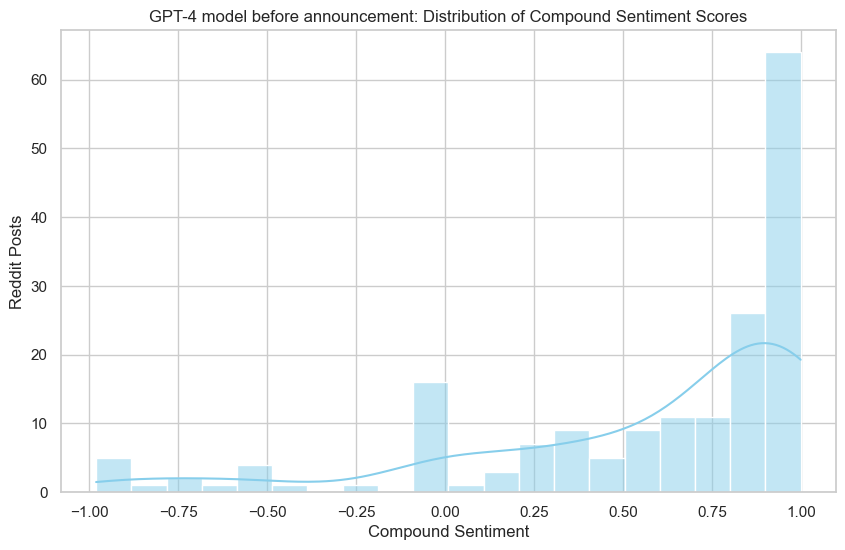

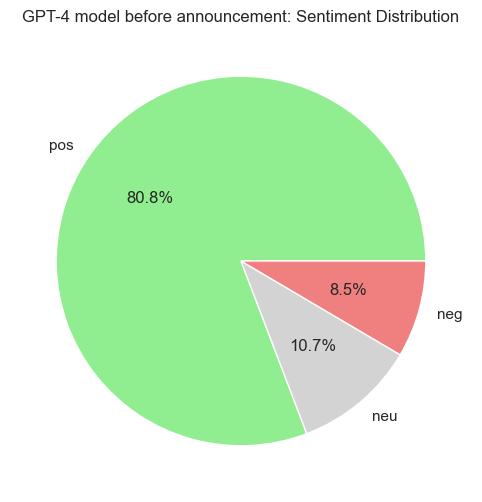

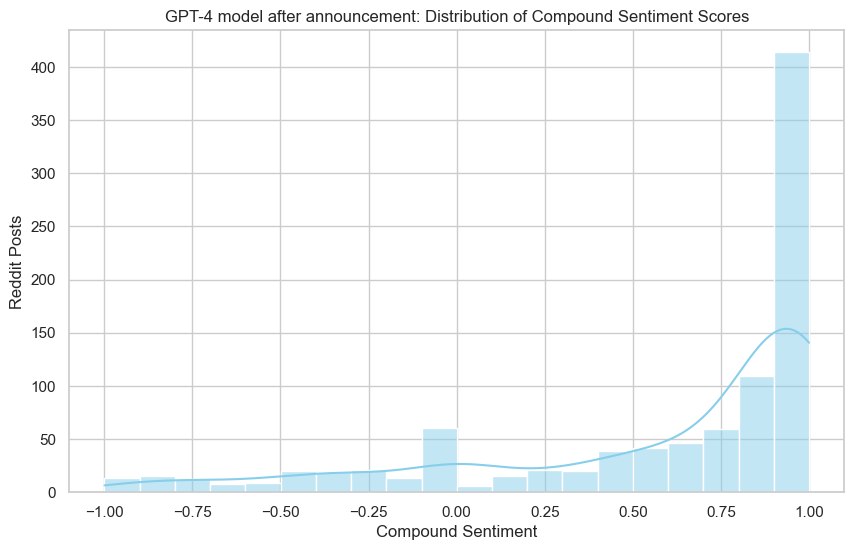

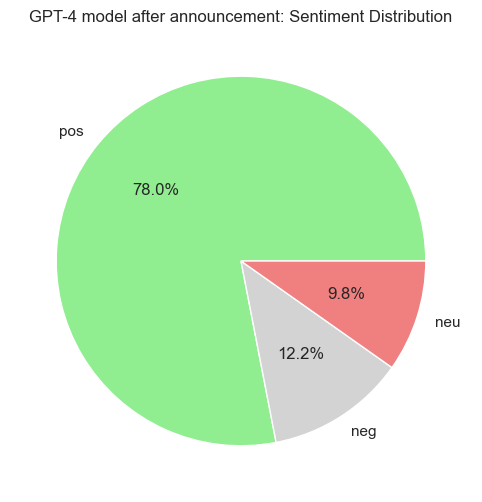

In [145]:
def visualize_sentiment(dataset, name):
    # Plot histogram of compound sentiment scores
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataset, x='compound', bins=20, kde=True, color='skyblue')
    plt.title(name + ': Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment')
    plt.ylabel('Reddit Posts')
    plt.show()

    # Plot pie chart of sentiment label distribution
    plt.figure(figsize=(8, 6))
    dataset['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightgray', 'lightcoral'])
    plt.title(name + ': Sentiment Distribution')
    plt.ylabel('')
    plt.show()
visualize_sentiment(dataset=df_gpt3, name='GPT-3 model')
visualize_sentiment(dataset=df_gpt4_before, name='GPT-4 model before announcement')
visualize_sentiment(dataset=df_gpt4_after, name='GPT-4 model after announcement')

# Preparing datasets, features, and targets

In [146]:
# Features to measure with MLflow
feature_names = ['launch_distance_f', 'num_comments_weighted', 'stickied', 'upvote_ratio', 'created', 'compound', 'pos', 'neg', 'neu']
# Target MLflow value
target_name = 'score_weighted'

# these variables should be represented as log of the original values
log_variables = ['score_weighted','num_comments', 'launch_distance_f', 'created']
# These features are disabled. Stickied items throw off the counts.
for feature in ['stickied']: feature_names.remove(feature)

def clean_dataset(dataset, csv_name, inplace=True):
    global log_variables, feature_names, target_name
    if inplace is True:
        _dataset = dataset
    else:
        _dataset = dataset.copy()
    for variable in log_variables:
        # Rename the variables to log_[variable] in the datasets
        log_variable = 'log_'+variable
        if target_name == variable:
            target_name = log_variable
        elif variable in feature_names:
            feature_names[feature_names.index(variable)] = log_variable
        _dataset[log_variable] = _dataset[variable].apply(lambda value: np.log(value+1))
    _dataset.dropna(subset=feature_names, how="any", inplace=True)
    _dataset.dropna(subset=target_name, how="any", inplace=True)
    
    ## Output file to csv
    _dataset.to_csv('/'.join(['output', csv_name + '.csv']))
    return _dataset

clean_dataset(df_gpt3, 'gpt3')
clean_dataset(df_gpt4_before, 'gpt4-before')
clean_dataset(df_gpt4_after, 'gpt4-after')

print(f"feature_names={feature_names}")
print(f"target_name={target_name}")

feature_names=['log_launch_distance_f', 'num_comments_weighted', 'upvote_ratio', 'log_created', 'compound', 'pos', 'neg', 'neu']
target_name=log_score_weighted


In [147]:
def describe_dataset(dataset, name):
    print(name)
    description_table = dataset.describe()

    # Convert the 'created' column to datetime
    description_table['created'] = pd.to_datetime(description_table['created'], unit='s')

    description_table = description_table.transpose()
    description_table.reset_index(inplace=True)

    # Create a PrettyTable object for the first half of columns
    table1 = PrettyTable()
    table1.field_names = description_table.columns[:1+len(description_table.columns)//2]

    # Create a PrettyTable object for the second half of columns, including the first column
    table2 = PrettyTable()
    table2.field_names = ['index'] + list(description_table.columns[1+len(description_table.columns)//2:])

    # Set the float format for all float columns
    float_format = "{:.2f}"

    # Set the timedelta format
    def format_timedelta(td):
        days = td.days
        hours, remainder = divmod(td.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return f"{days} days" # {hours:02}:{minutes:02}:{seconds:02}
    
    # Format date
    def format_date(dt):
        return dt.strftime("%Y-%m-%d") # %H:%M:%S

    # Add rows to the tables
    for row in description_table.itertuples(index=False):
        # Convert timedelta values to formatted strings
        row = list(row)
        for i, value in enumerate(row):
            if isinstance(value, pd.Timedelta):
                row[i] = format_timedelta(value)
            elif isinstance(value, pd.Timestamp):
                row[i] = format_date(value)
        # Format float values
        row = [float_format.format(value) if isinstance(value, float) else value for value in row]
        # Add row to the first table
        table1.add_row(row[:1+len(description_table.columns)//2])
        # Add row to the second table
        table2.add_row([row[0]] + row[1+len(description_table.columns)//2:])

    # Print the tables
    print(table1)
    print(table2)

describe_dataset(dataset=df_gpt3, name='GPT-3 model') #2010 count
describe_dataset(dataset=df_gpt4_before, name='GPT-4 model before announcement') #842 count
describe_dataset(dataset=df_gpt4_after, name='GPT-4 model after announcement') #7186 count

GPT-3 model
+-----------------------+------------+------------+------------+------------+
|         index         |   count    |    mean    |    std     |    min     |
+-----------------------+------------+------------+------------+------------+
|         index         |   423.00   |  26424.90  |  16880.47  |    3.00    |
|       Unnamed: 0      |   423.00   |   96.02    |   77.69    |    0.00    |
|      upvote_ratio     |   423.00   |    0.78    |    0.22    |    0.11    |
|         score         |   423.00   |   57.76    |   136.48   |    0.00    |
|      num_comments     |   423.00   |   45.03    |   271.09   |    0.00    |
|        created        | 1970-01-01 | 2022-12-27 | 1970-01-24 | 2022-11-01 |
|     score_weighted    |   423.00   |  4828.20   |  10120.18  |    0.00    |
| num_comments_weighted |   423.00   |  3584.36   |  17446.22  |    0.00    |
|    launch_distance    |    423     |  76 days   |  23 days   |  41 days   |
|   launch_distance_f   |   423.00   |   76.77    | 

# Run MLflow experiment
Linear regression analysis. Remove "stickied" Reddit posts from data.

Test model against data after GPT-4 launch.

In [148]:
# Enable automatic logging to MLflow
mlflow.set_experiment("Reddit GPT Hype")
mlflow.autolog()

def trim_dataset(dataset, q_lower = 0, q_upper = 1):
    global target_name
    quantile = target_name
    _dataset = dataset.copy()
    # Trim dataset by the quantile for the target for training
    _dataset = _dataset[(_dataset['stickied'] == False)]
    _q_lower = _dataset[quantile].quantile(q_lower)
    _q_upper = _dataset[quantile].quantile(q_upper)
    _dataset = _dataset[(_dataset[quantile] >= _q_lower) &
                        (_dataset[quantile] <= _q_upper)]
    return _dataset

def model_testing(dataset, test):
    _dataset = dataset.copy()
    _test = test.copy()
    # Trim upper and lower quantiles
    _dataset = trim_dataset(_dataset)
    _test = trim_dataset(_test)
    # Sort values for displaying in graph
    _dataset = dataset
    _test = _test
    # Set X features and y targets
    X_test = _test.loc[:, _test.columns[:,None] == feature_names]
    y_test = _test.loc[:, _test.columns == target_name].values
    X = _dataset.loc[:, _dataset.columns[:,None] == feature_names]
    y = _dataset.loc[:, _dataset.columns == target_name].values

    lr_params =  {}
    lr = LinearRegression(**lr_params)

    # MLflow triggers logging automatically upon model fitting
    lr.fit(X, y)
    y_pred = lr.predict(X_test)

    return {'X': X, 'y': y, 'X_test': X_test, 'y_actual': y_test, 'y_pred': y_pred, 'coef': lr.coef_}

gpt3_model = model_testing(df_gpt3, df_gpt4_after)
#gpt3_model_same = model_testing(df_gpt3, df_gpt3)
gpt4_model = model_testing(df_gpt4_before, df_gpt4_after)
#gpt4_model_same = model_testing(df_gpt4_before, df_gpt4_before)

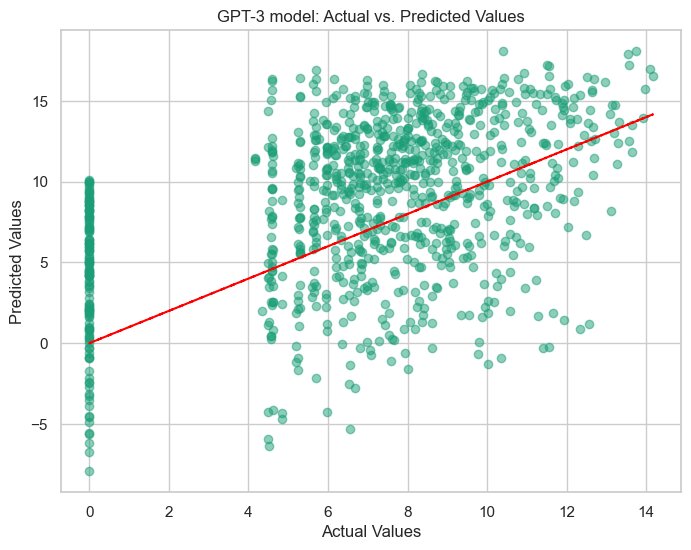

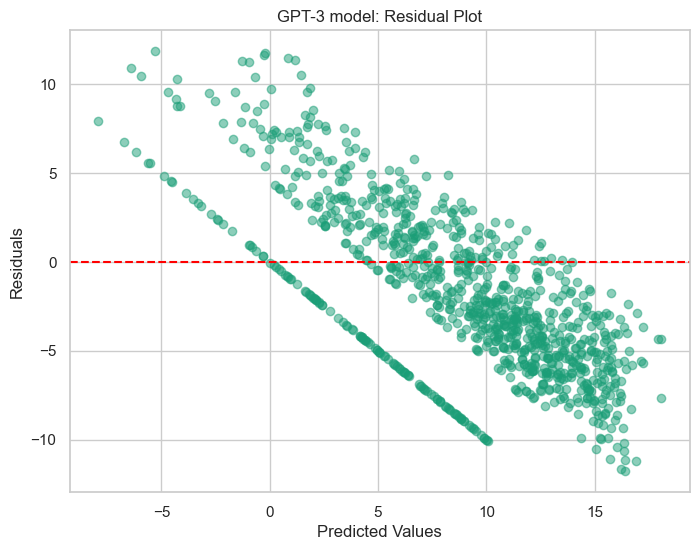

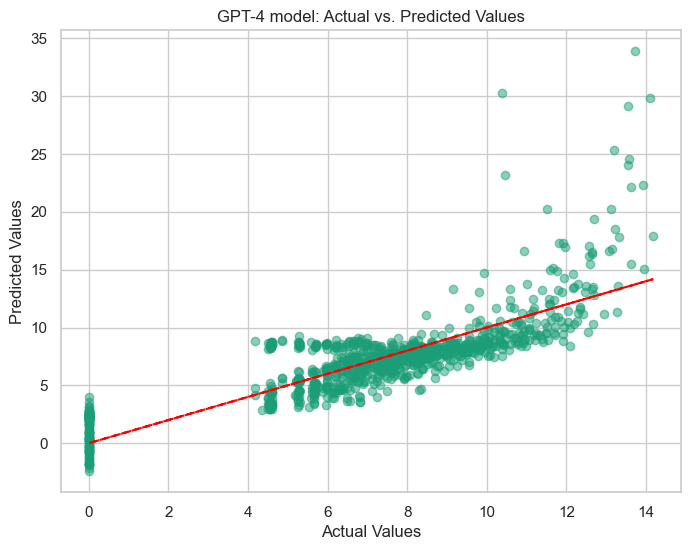

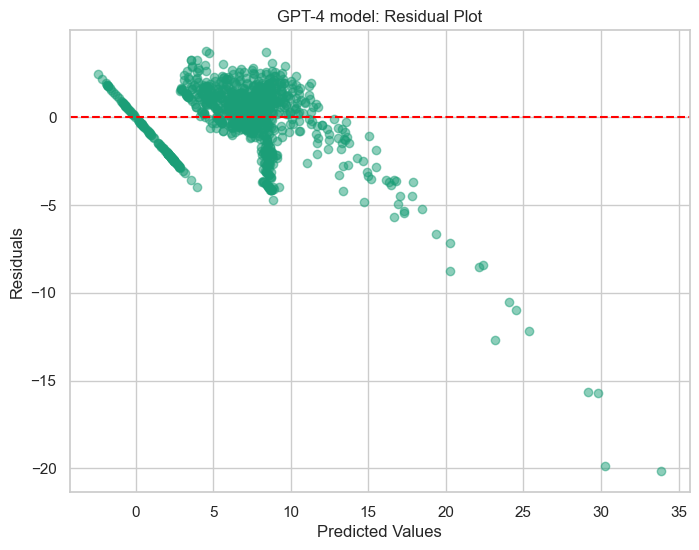

In [149]:
# Plot accuracy of the models
def plot_accuracy(model, name):
    actual_values = model['y_actual']
    predicted_values = model['y_pred']

    # Scatter plot of actual versus predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot(actual_values, actual_values, color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(name + ": Actual vs. Predicted Values")
    plt.grid(True)
    plt.show()

    # Residual plot
    residuals = actual_values - predicted_values
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted_values, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(name + ": Residual Plot")
    plt.grid(True)
    plt.show()

    # Coefficient plot (if coefficients are available in the MLflow run)
    if "coefficients" in model:
        coefficients = model["coef"]
        plt.figure(figsize=(8, 6))
        sns.barplot(x=coefficients.index, y=coefficients.values)
        plt.xlabel("Independent Variables")
        plt.ylabel("Coefficients")
        plt.title("Coefficient Plot")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
plot_accuracy(model=gpt3_model, name='GPT-3 model')
plot_accuracy(model=gpt4_model, name='GPT-4 model')

# Feature Plots

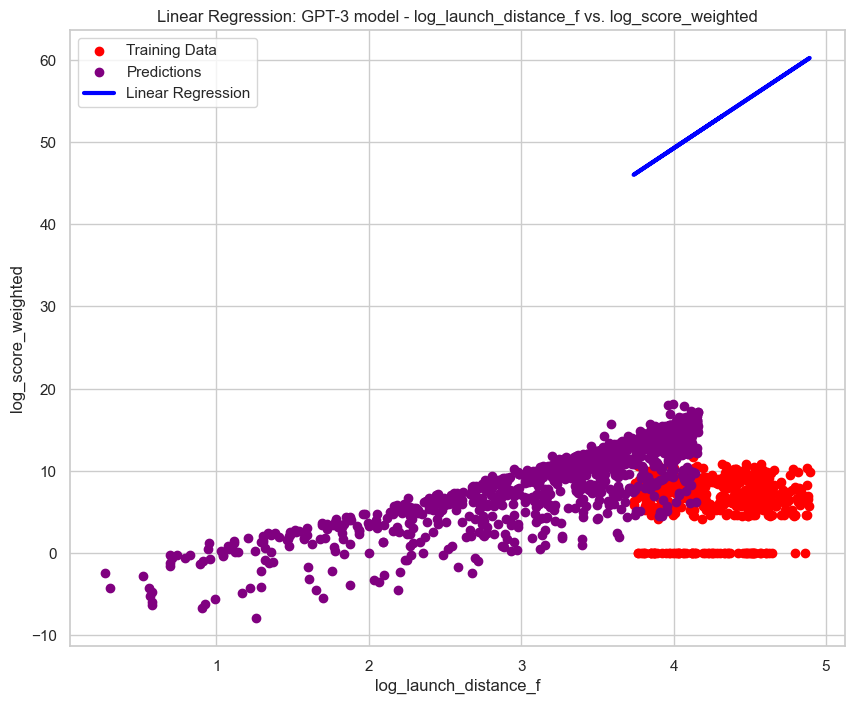

log_launch_distance_f=12.31594317326375


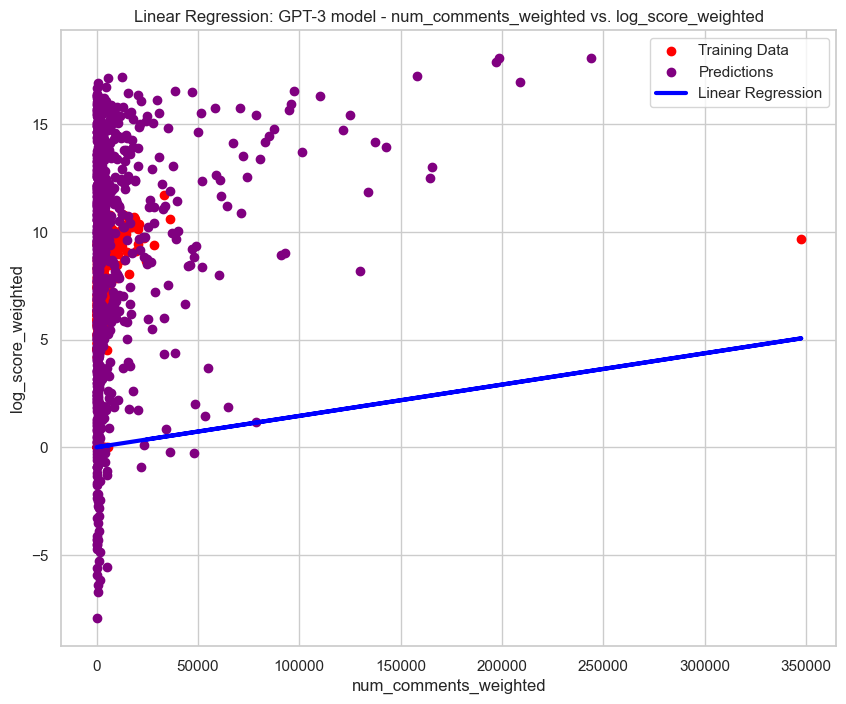

num_comments_weighted=1.4537644106810799e-05


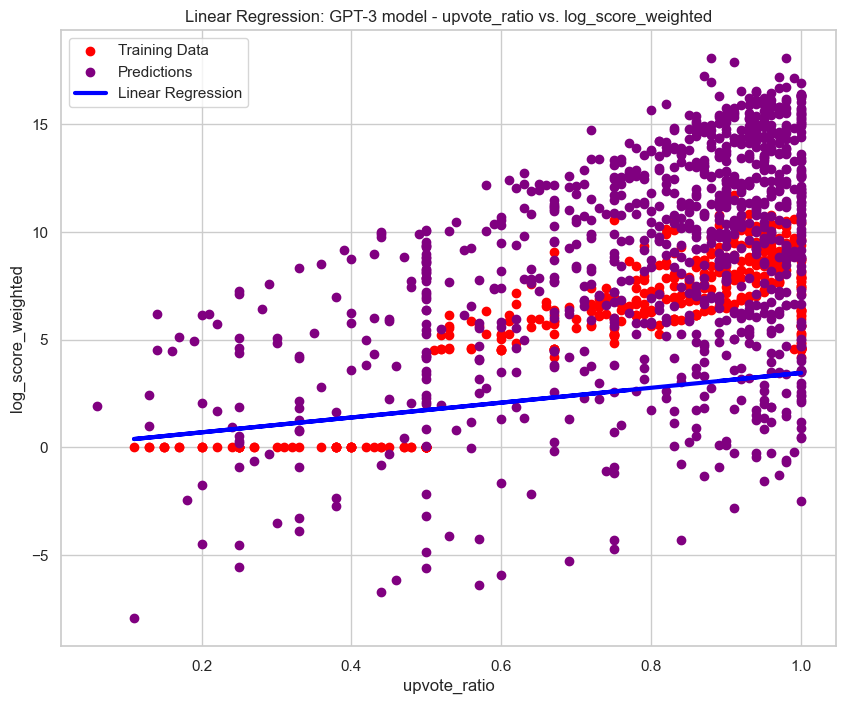

upvote_ratio=3.45066727730928


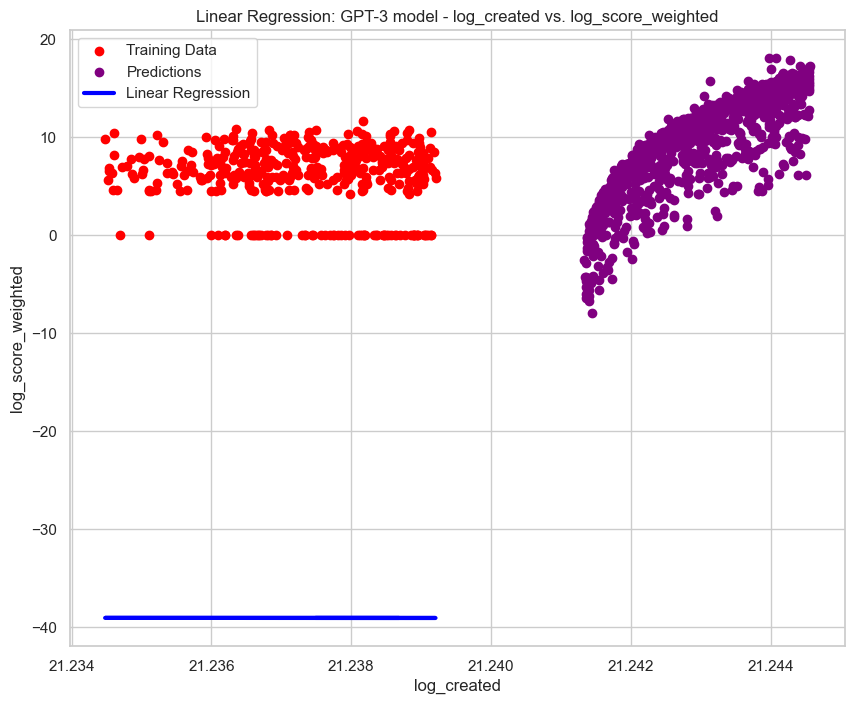

log_created=-1.8386626862531719


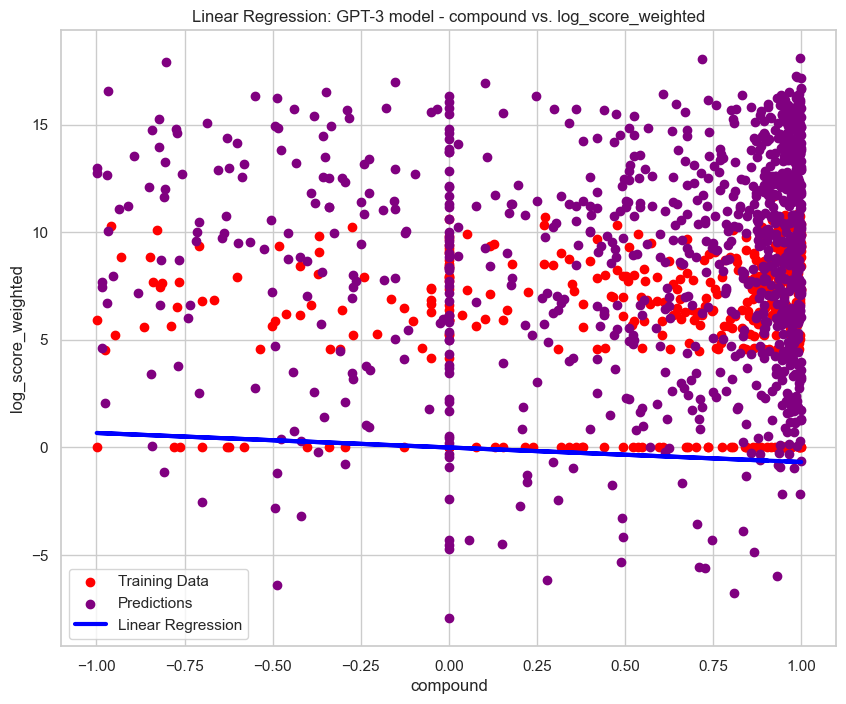

compound=-0.6746207277244394


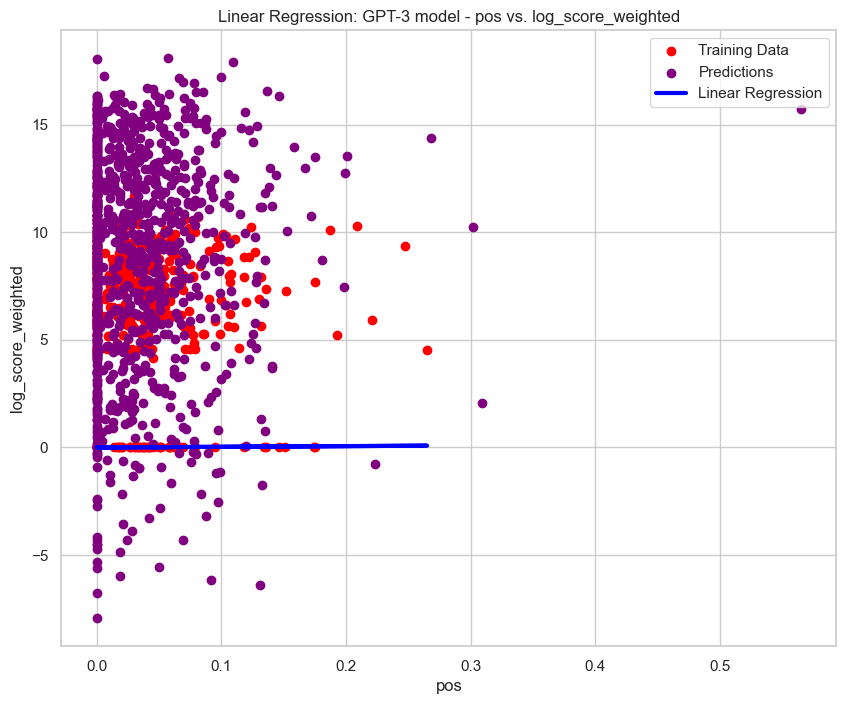

pos=0.3152746111112006


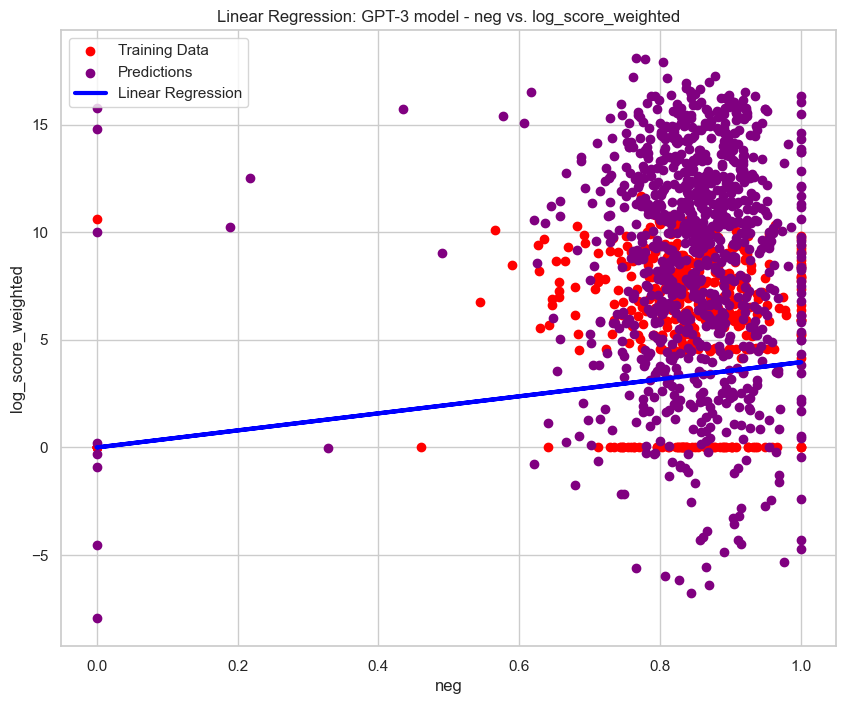

neg=3.9634039802209693


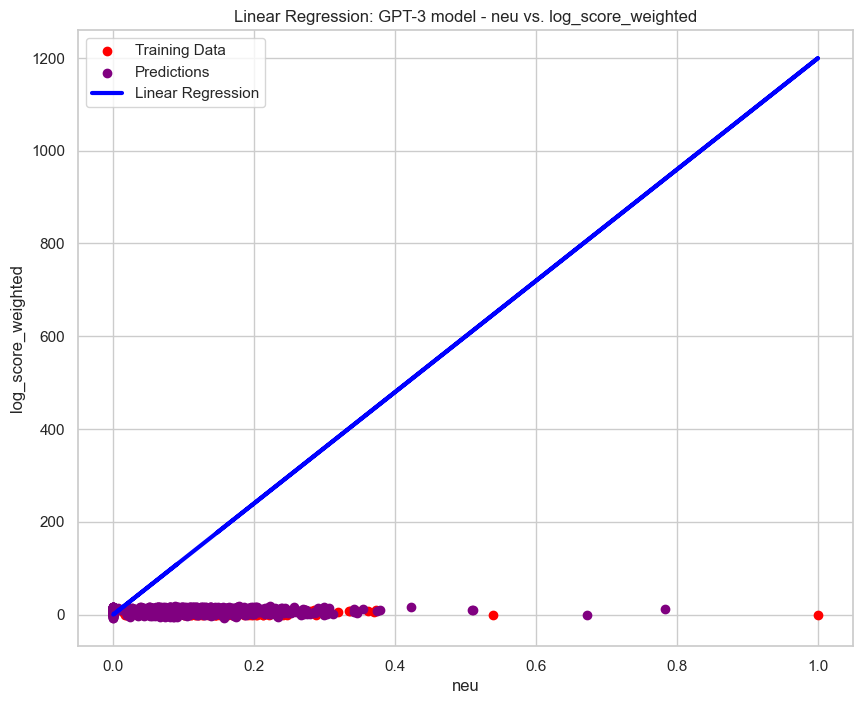

neu=1199.350646473277


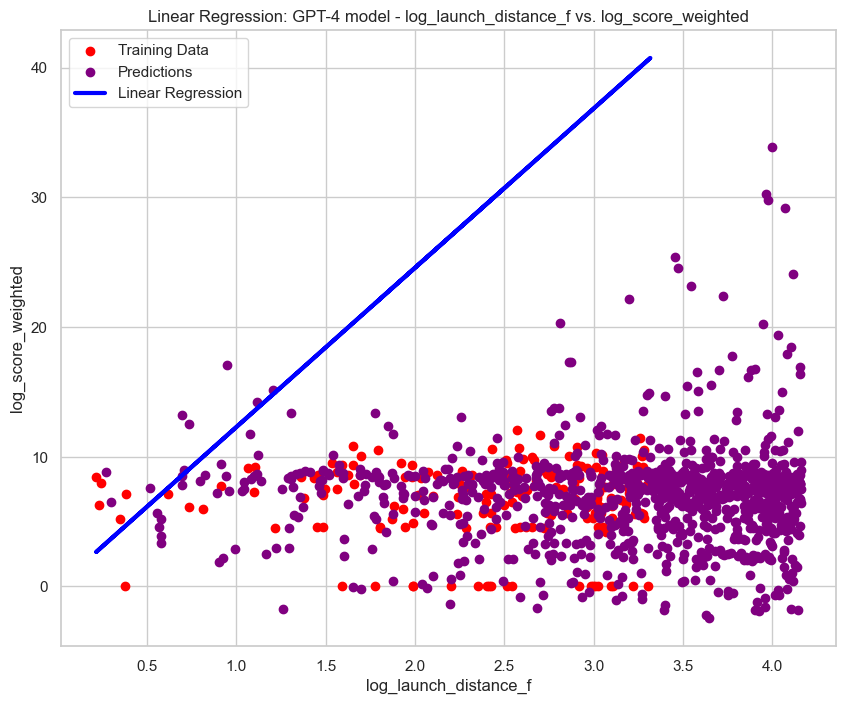

log_launch_distance_f=12.281998058417082


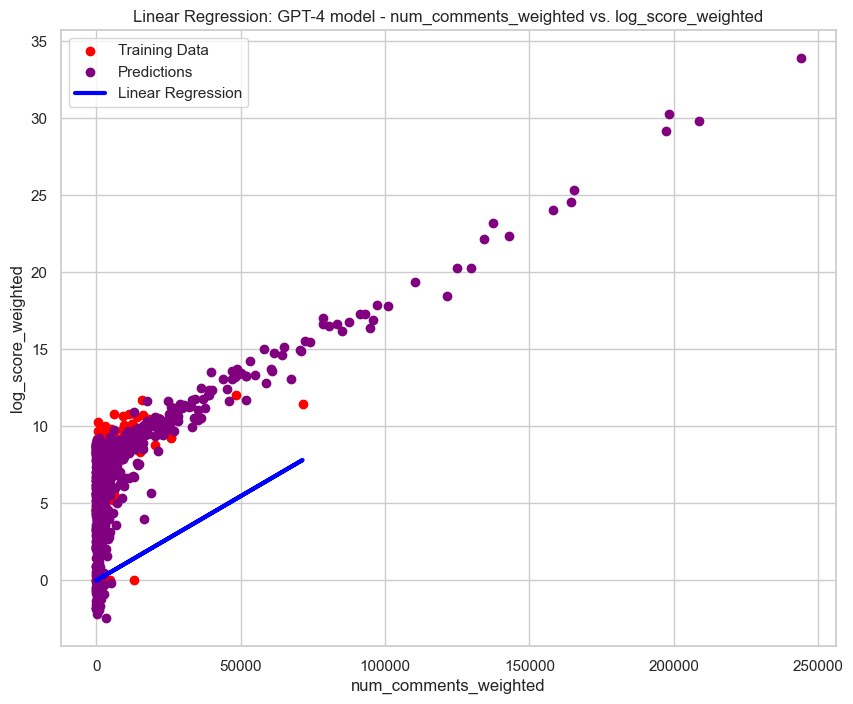

num_comments_weighted=0.00010934516756302794


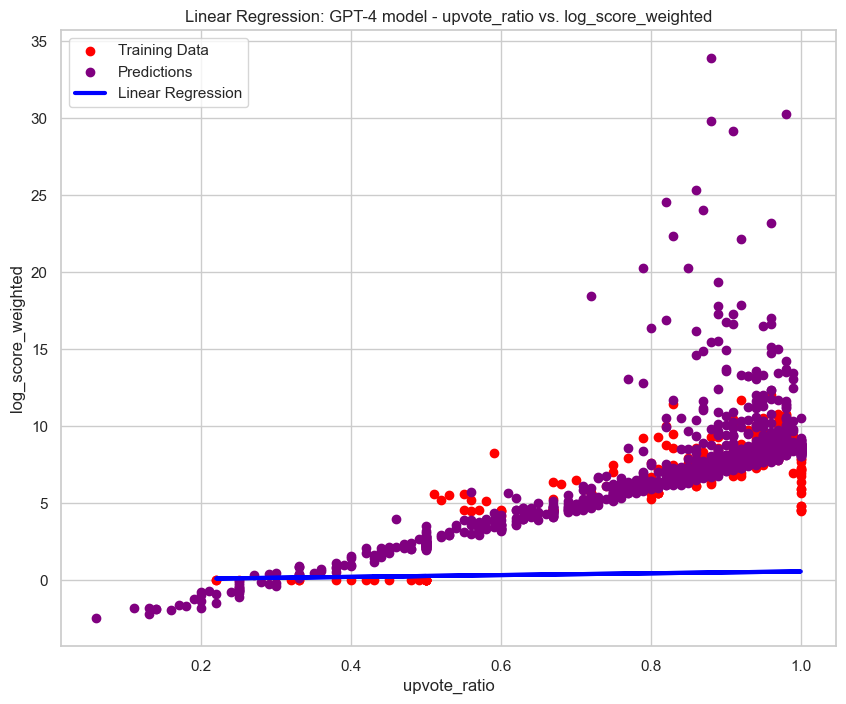

upvote_ratio=0.585342367127611


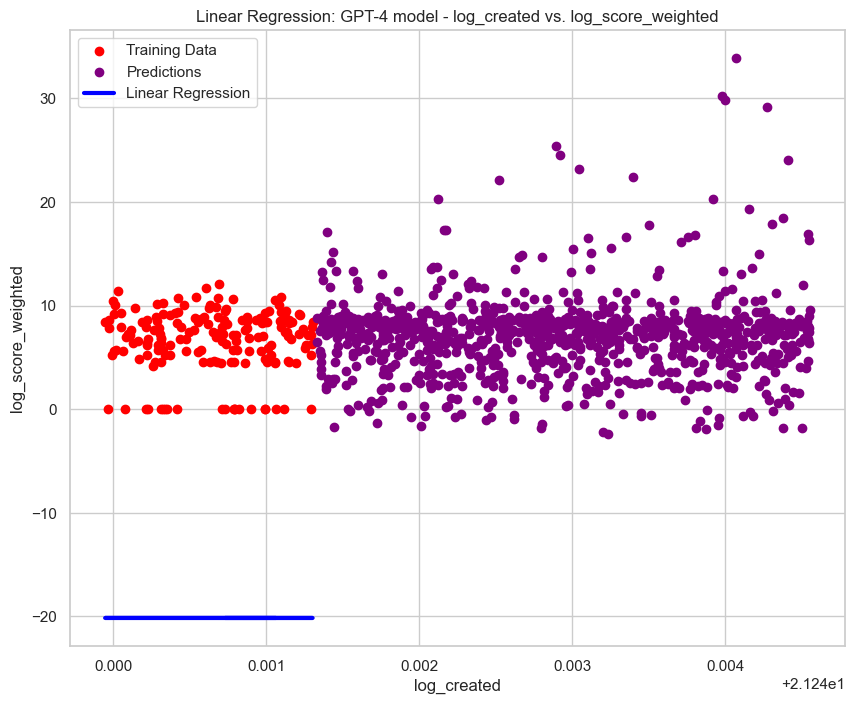

log_created=-0.9485840027443121


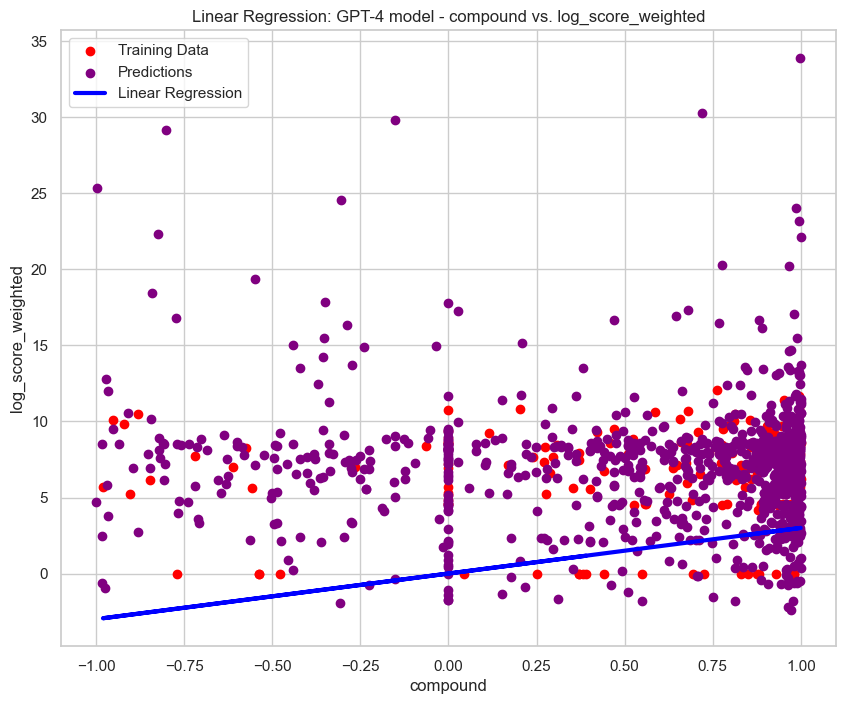

compound=3.000489670520865


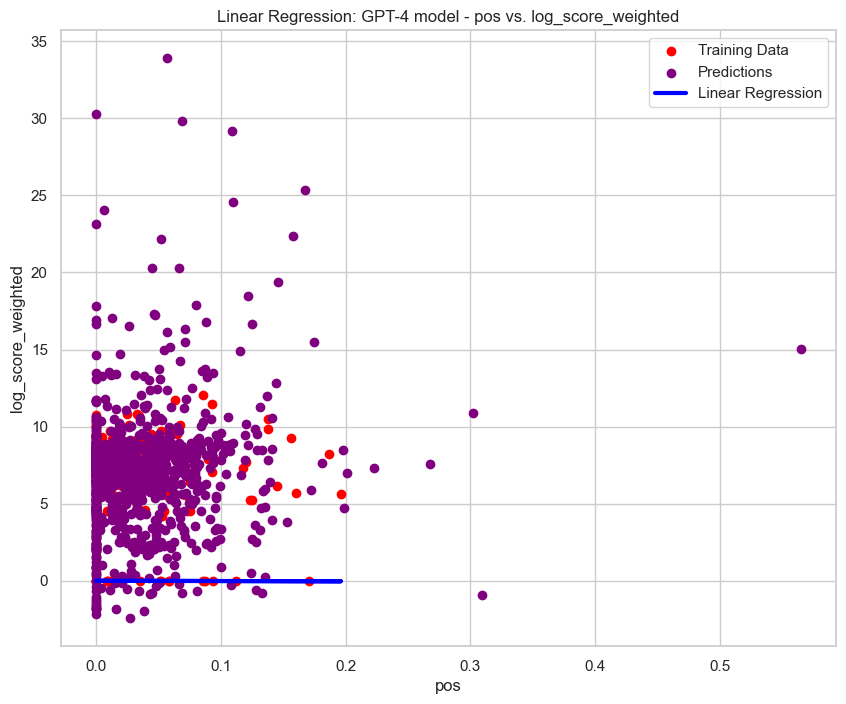

pos=-0.17175511624053064


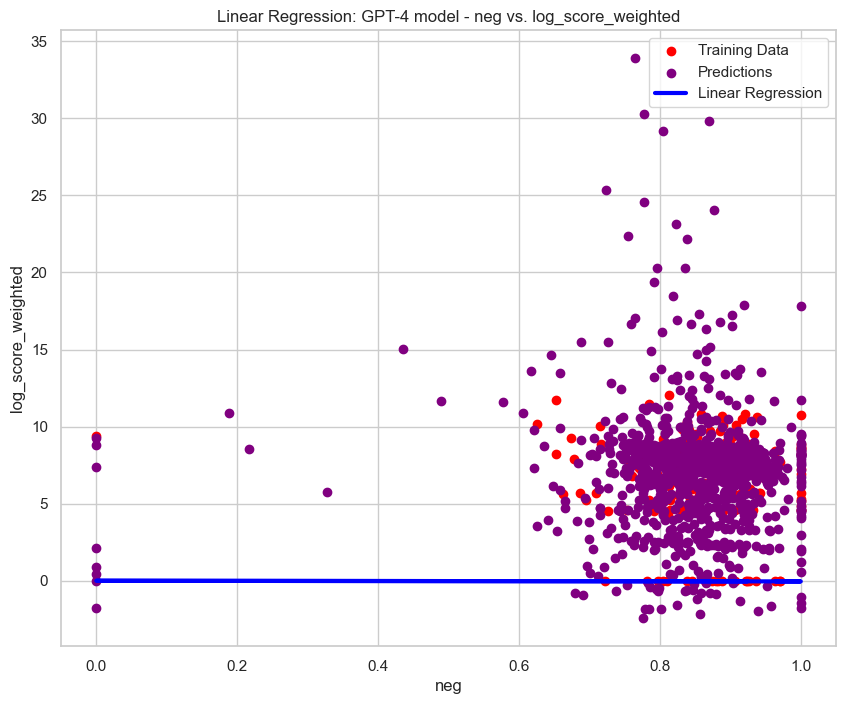

neg=-0.04094390866813988


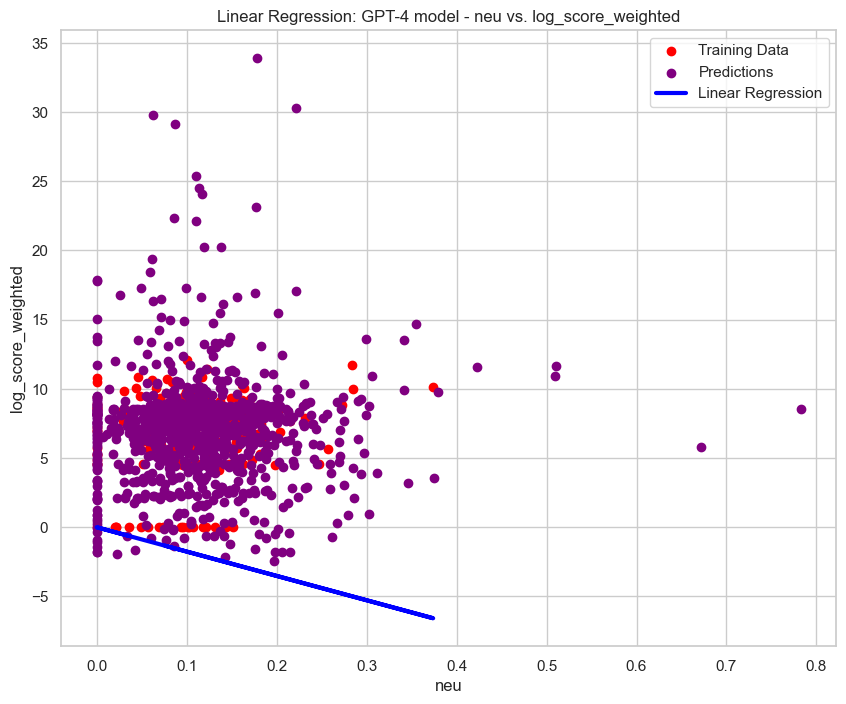

neu=-17.59220324007005


In [150]:
def plot_features(model, name):
    for coef in feature_names:
        feature = coef
        plt.scatter(model['X'][feature], model['y'], color='red', label='Training Data')
        plt.scatter(model['X_test'][feature], model['y_pred'], color='purple', label='Predictions')
        y_fit = model['X'][feature] * model['coef'][0][feature_names.index(feature)]
        plt.plot(model['X'][feature], y_fit, color='blue', linewidth=3, label='Linear Regression')
        plt.xlabel(f"{feature}")
        plt.ylabel(f"{target_name}")
        plt.title(f"Linear Regression: {name} - {feature} vs. {target_name}")
        plt.legend()
        plt.show()
        print(f"{coef}={model['coef'][0][feature_names.index(coef)]}")
plot_features(model=gpt3_model, name='GPT-3 model')
plot_features(model=gpt4_model, name='GPT-4 model')

# Categorical Distributions

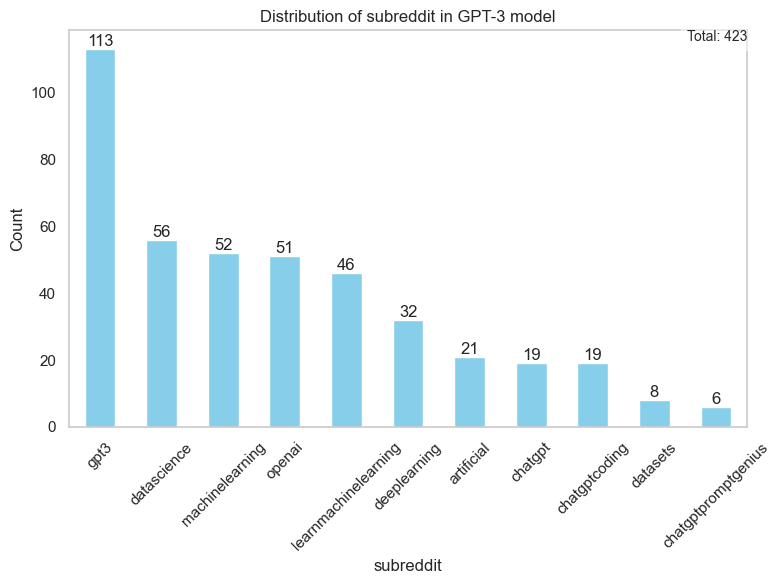

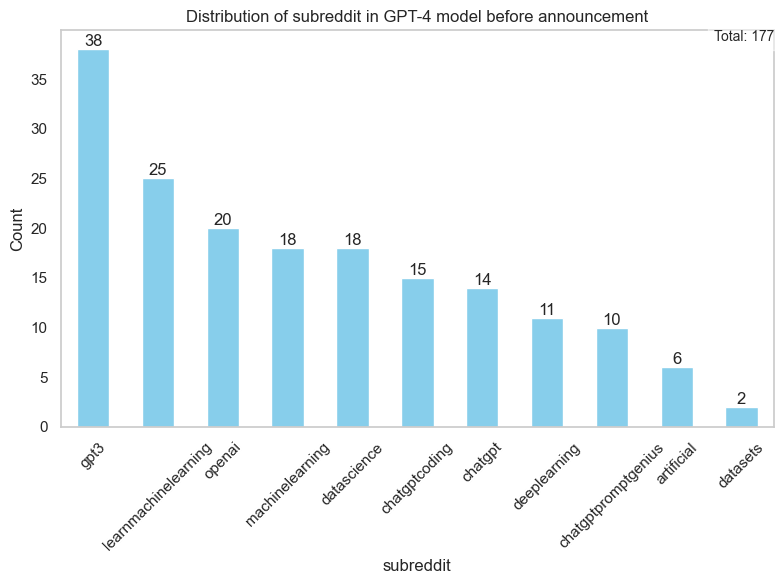

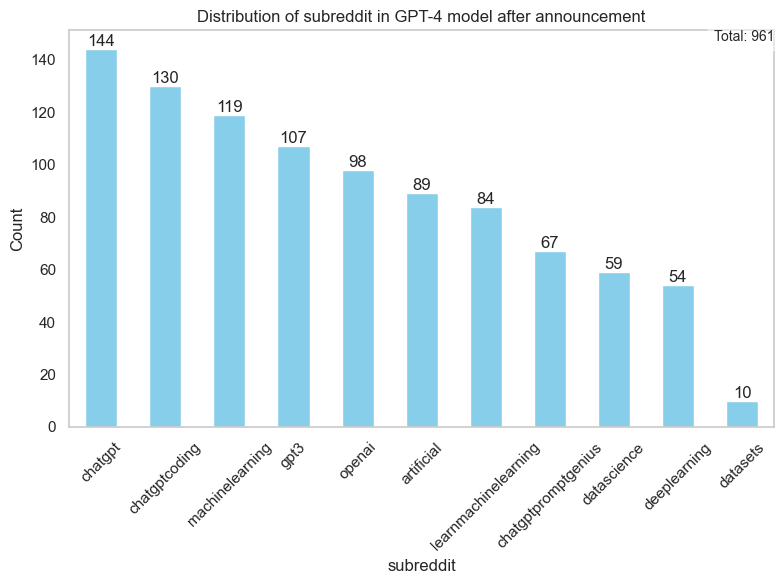

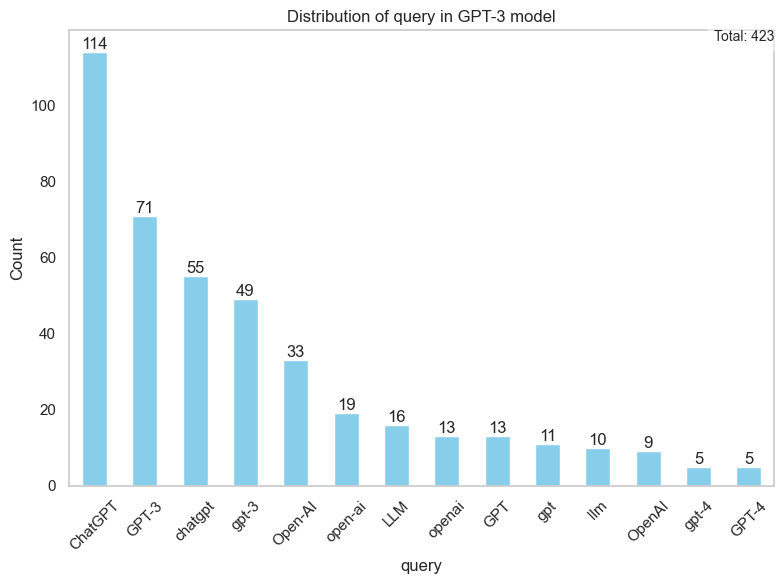

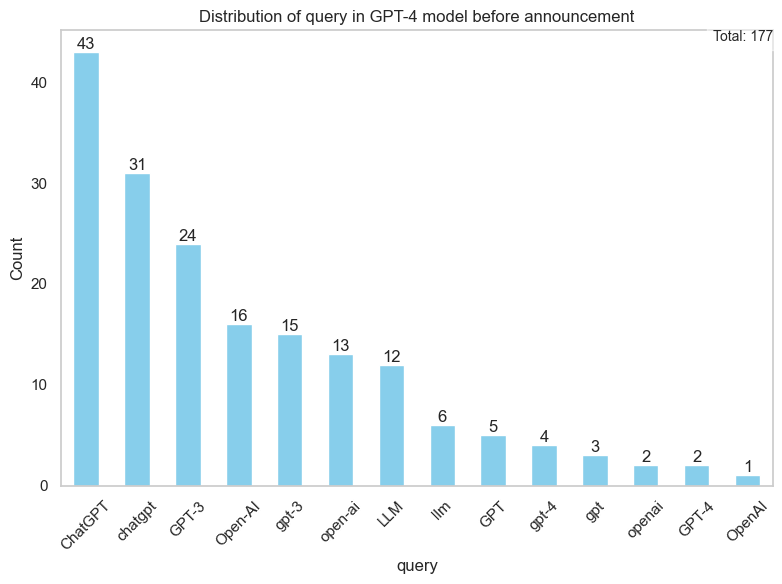

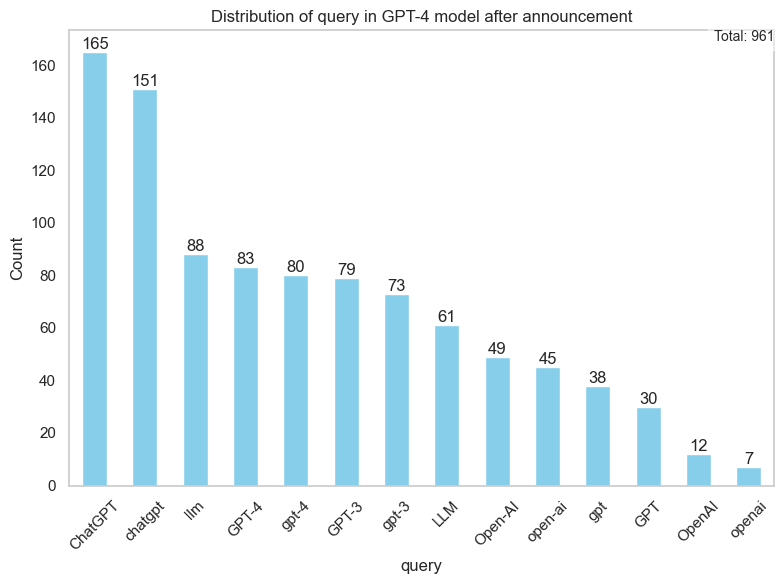

In [151]:
def plot_distributions(dataset, name, category):
    # Count the occurrences of each category value
    category_counts = dataset[category].value_counts()

    # Plot the distribution as a bar chart
    plt.figure(figsize=(8, 6))
    ax = category_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {category} in {name}')
    plt.xlabel(category)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    ax.grid(False)  # Remove gridlines


    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
        
    # Add total count outside the plot
    total_count = dataset[category].count()
    plt.text(1, 1, f'Total: {total_count}', ha='right', va='top', transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
for category in ['subreddit', 'query']:
    plot_distributions(dataset=df_gpt3, name='GPT-3 model', category=category)
    plot_distributions(dataset=df_gpt4_before, name='GPT-4 model before announcement', category=category)
    plot_distributions(dataset=df_gpt4_after, name='GPT-4 model after announcement', category=category)

# Heatmap of MLflow runs

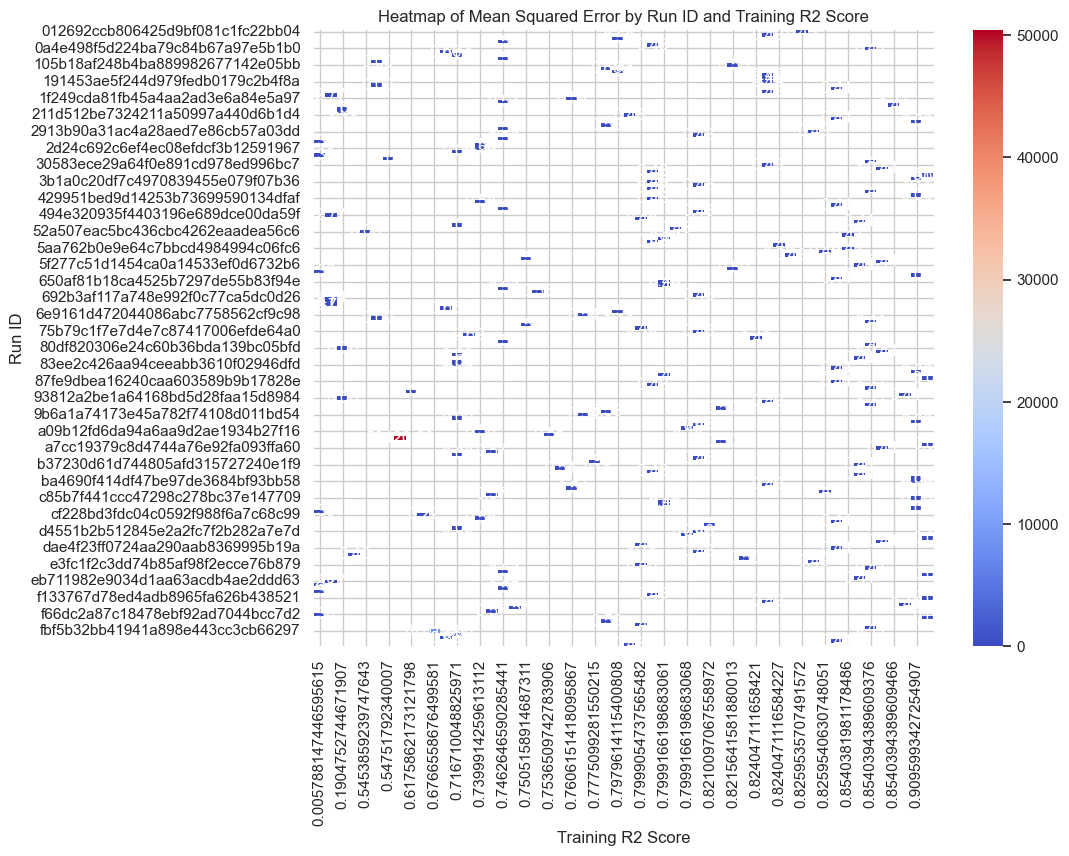

In [152]:
# Fetch the data from MLflow
experiments = mlflow.search_runs()

# Organize the data into a DataFrame
heatmap_data = experiments.pivot_table(index='run_id', columns='metrics.training_r2_score', values='metrics.training_mean_squared_error')

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Heatmap of Mean Squared Error by Run ID and Training R2 Score')
plt.xlabel('Training R2 Score')
plt.ylabel('Run ID')
plt.show()